In [24]:
#Importing necessary libraries

from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, isnan, when, count


Data Loading and Initial Exploration

In [2]:
#Initialize Spark Session
spark = SparkSession.builder.appName("FlightDelayPrediction").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/04 14:25:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.setLogLevel("ERROR")

In [4]:
#Load the dataset
df = spark.read.csv("../Dataset/Combined_Flights_2022.csv",header=True,inferSchema=True)

In [5]:
#Partitioning the dataset
df = df.repartition(10)

In [6]:
#Display schema and first 10 rows
df.printSchema()
df.show(20)

root
 |-- FlightDate: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+--------------------+---------+-------------+--------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|

In [7]:
#Count the total number of rows
row_count = df.count()
print("Total rows:", row_count)

Total rows: 4078318


Data Cleaning and Transformation

In [25]:
df.count()

3944916

In [9]:
# Check for null values
null_counts = df.select([count(when(col(c).isNull() | (col(c).cast("string") == ""), c)).alias(c) if df.schema[c].dataType != "boolean" else count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|

In [26]:
df = df.fillna(0)

In [11]:
# Remove duplicates
df = df.dropDuplicates()

In [27]:
# Filter invalid rows: For example, remove rows where delays are negative
df = df.filter((df["DepDelayMinutes"]>= 0) & (df["ArrDelayMinutes"]>= 0))

In [28]:
df.show()

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+--------------------+---------+-------------+--------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|

Data Analysis Using Spark SQL

In [14]:
# Register the cleaned DataFrame as a SQL temporary view

df.createOrReplaceTempView("flight_data")

In [15]:
# Aggregation: Calculate summary statistics for delays
spark.sql("""
    SELECT 
        AVG(DepDelayMinutes) AS avg_dep_delay,
        STDDEV(DepDelayMinutes) AS stddev_dep_delay,
        AVG(ArrDelayMinutes) AS avg_arr_delay,
        STDDEV(ArrDelayMinutes) AS stddev_arr_delay
    FROM flight_data
""").show()

+------------------+-----------------+------------------+-----------------+
|     avg_dep_delay| stddev_dep_delay|     avg_arr_delay| stddev_arr_delay|
+------------------+-----------------+------------------+-----------------+
|15.940134086505264|52.16239928825893|15.783071426615928|51.98423581313926|
+------------------+-----------------+------------------+-----------------+



In [16]:
# Grouping: Average departure delay by airline

spark.sql("""
    SELECT 
        Airline, 
        AVG(DepDelayMinutes) AS avg_dep_delay
    FROM flight_data
    GROUP BY Airline
    ORDER BY avg_dep_delay DESC
""").show()

+--------------------+------------------+
|             Airline|     avg_dep_delay|
+--------------------+------------------+
|     JetBlue Airways|28.913369286392374|
|Frontier Airlines...|  23.4853028822085|
|       Allegiant Air|22.665417589280644|
|GoJet Airlines, L...|20.106726957383547|
|  Mesa Airlines Inc.|18.805355872144528|
|    Spirit Air Lines| 18.36243988457839|
|American Airlines...|17.632990873577082|
|         Comair Inc.|   16.827018096592|
|United Air Lines ...|16.338848566321307|
|Commutair Aka Cha...|16.277818096687348|
|Southwest Airline...| 15.92439971582852|
|SkyWest Airlines ...|14.935353732532983|
|   Republic Airlines| 14.70693922794632|
|Delta Air Lines Inc.|13.741698787721436|
|   Endeavor Air Inc.|13.177635965330031|
|Air Wisconsin Air...|13.055913756641049|
|Capital Cargo Int...|11.978940164254986|
|           Envoy Air| 10.12833114897335|
|Alaska Airlines Inc.|10.069359506932761|
|         Horizon Air|  8.86154960173787|
+--------------------+------------

In [17]:

# Time-based analysis: Delay trends by month
spark.sql("""
    SELECT 
        Year, Month, 
        AVG(DepDelayMinutes) AS avg_dep_delay,
        AVG(ArrDelayMinutes) AS avg_arr_delay
    FROM flight_data
    GROUP BY Year, Month
    ORDER BY Year, Month
""").show()

+----+-----+------------------+------------------+
|Year|Month|     avg_dep_delay|     avg_arr_delay|
+----+-----+------------------+------------------+
|2022|    1|14.554631481854035|14.354921483258492|
|2022|    2| 14.38924364119108| 14.22176289364896|
|2022|    3| 15.23190499919821|15.282290116612899|
|2022|    4|15.979667586794719|15.949220248947393|
|2022|    5| 15.19160603757194|15.079478974372895|
|2022|    6|18.224888112801544|17.849852879505566|
|2022|    7|17.589301722785844|17.326682130740213|
+----+-----+------------------+------------------+



Insights or patterns observed

In [18]:
# Delay patterns by month
spark.sql("""
    SELECT 
        Year, Month, 
        AVG(DepDelayMinutes) AS avg_dep_delay,
        AVG(ArrDelayMinutes) AS avg_arr_delay
    FROM flight_data
    GROUP BY Year, Month
    ORDER BY Year, Month
""").show()

+----+-----+------------------+------------------+
|Year|Month|     avg_dep_delay|     avg_arr_delay|
+----+-----+------------------+------------------+
|2022|    1|14.554631481854035|14.354921483258492|
|2022|    2| 14.38924364119108| 14.22176289364896|
|2022|    3| 15.23190499919821|15.282290116612899|
|2022|    4|15.979667586794719|15.949220248947393|
|2022|    5| 15.19160603757194|15.079478974372895|
|2022|    6|18.224888112801544|17.849852879505566|
|2022|    7|17.589301722785844|17.326682130740213|
+----+-----+------------------+------------------+



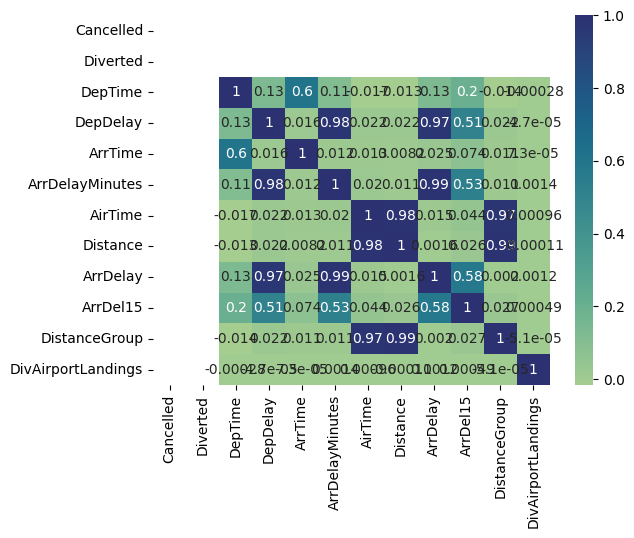

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns for correlation analysis
cols = ["Cancelled", "Diverted","DepTime", "DepDelay", "ArrTime", 
        "ArrDelayMinutes", "AirTime","Distance","ArrDelay", "ArrDel15", "DistanceGroup", "DivAirportLandings"]

# Compute the correlation matrix for the selected columns
corr_matrix = df.select(cols).toPandas().corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="crest")

# Show the plot
plt.show()

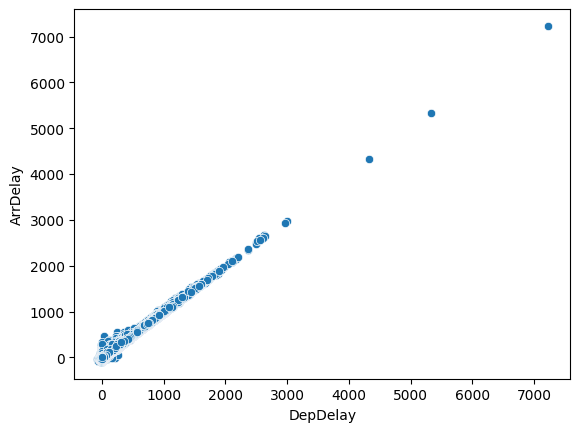

In [20]:

# Select departure delay and arrival delay columns
delay_df = df.select("DepDelay", "ArrDelay").toPandas()

# Create scatterplot using Seaborn
sns.scatterplot(x="DepDelay", y="ArrDelay", data=delay_df)

# Show plot
plt.show()

Machine Learning Model(Regression/Classification)

Split the dataset into training and testing sets.
• Choose the appropriate ML problem based on the dataset:
o Regression: Predict a continuous label (e.g., predicting taxi fare, house prices).
o Classification: Predict a categorical label (e.g., predicting product rating as high/low,
predicting whether a flight will be delayed).
• Build a pipeline using PySpark MLlib that includes:
o Feature engineering: Extract or transform relevant features.
o VectorAssembler: Combine all features into a single vector.
o Model selection: Use an appropriate algorithm (e.g., LinearRegression,
LogisticRegression, RandomForestClassifier).
o Model evaluation: Evaluate the model using metrics such as RMSE for regression or
accuracy/F1-score for classification.

In [21]:
train_data, test_data= df.randomSplit([0.8, 0.2], seed=123)

In [22]:
print('Train:', train_data.count())
print('Test:',test_data.count())

Train: 3157183


Test: 787733


In [23]:
bd3=bd2.select('DepDelay',
             'Distance', 
             'DayOfWeek',
             'IndexUniqueCarrier', 
             'TimeSlot',
             'Delayed')
             
bd3.limit(10).toPandas()

NameError: name 'bd2' is not defined

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer  
from pyspark.sql.functions import col

# bd3_40000 = bd3.limit(40000)

a1 = VectorAssembler(inputCols=['DepDelay', 'Distance',  'DayOfWeek',  'IndexUniqueCarrier',  'TimeSlot'],  outputCol='features')
bd4 = a1.transform(bd3).select(col("Delayed").cast('double').alias("label"),'features')  
stringIndexer = StringIndexer(inputCol = 'label', outputCol = 'label2')  
sI = stringIndexer.fit(bd4)  
bd4 = sI.transform(bd4)  
bd4 = bd4.select('label2','features')

Model Tuning and Evaluation

Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

from time import time

start_time = time()

# Train a RandomForest model
rf = RandomForestClassifier(labelCol="label2", 
     featuresCol="features", 
     numTrees=500,
     maxDepth=3, 
     seed = 1) 

model = rf.fit(train_data)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

IllegalArgumentException: features does not exist. Available: FlightDate, Airline, Origin, Dest, Cancelled, Diverted, CRSDepTime, DepTime, DepDelayMinutes, DepDelay, ArrTime, ArrDelayMinutes, AirTime, CRSElapsedTime, ActualElapsedTime, Distance, Year, Quarter, Month, DayofMonth, DayOfWeek, Marketing_Airline_Network, Operated_or_Branded_Code_Share_Partners, DOT_ID_Marketing_Airline, IATA_Code_Marketing_Airline, Flight_Number_Marketing_Airline, Operating_Airline, DOT_ID_Operating_Airline, IATA_Code_Operating_Airline, Tail_Number, Flight_Number_Operating_Airline, OriginAirportID, OriginAirportSeqID, OriginCityMarketID, OriginCityName, OriginState, OriginStateFips, OriginStateName, OriginWac, DestAirportID, DestAirportSeqID, DestCityMarketID, DestCityName, DestState, DestStateFips, DestStateName, DestWac, DepDel15, DepartureDelayGroups, DepTimeBlk, TaxiOut, WheelsOff, WheelsOn, TaxiIn, CRSArrTime, ArrDelay, ArrDel15, ArrivalDelayGroups, ArrTimeBlk, DistanceGroup, DivAirportLandings